# Regresión lineal para una relación no lineal características-target

Mostraremos que incluso si la parametrización de los modelos lineales no se adapta de manera nativa al problema en cuestión, todavía es posible hacer que los modelos lineales sean más expresivos mediante la ingeniería de características (adicionales).

Un pipeline de ML que combina un paso de ingeniería de características no lineal seguido de un paso de regresión lineal puede considerarse un modelo de regresión no lineal en su conjunto.

In [1]:
import numpy as np

rng = np.random.RandomState(0)

n_sample = 100
data_max, data_min = 1.4, -1.4
len_data = (data_max - data_min)
# sort the data to make plotting easier later
data = np.sort(rng.rand(n_sample) * len_data - len_data / 2)
noise = rng.randn(n_sample) * .3
target = data ** 3 - 0.5 * data ** 2 + noise

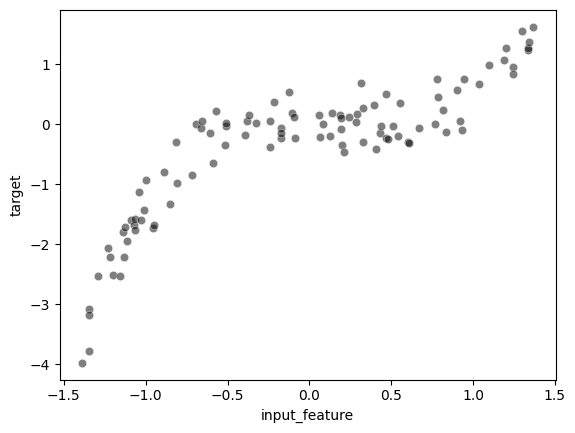

In [2]:
import pandas as pd

full_data = pd.DataFrame({"input_feature": data, "target": target})
import seaborn as sns

_ = sns.scatterplot(data=full_data, x="input_feature", y="target",
                    color="black", alpha=0.5)

In [3]:
# Hacemos reshape del aray para que tenga una sola columna
data = data.reshape((-1, 1))
data.shape



(100, 1)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
linear_regression.fit(data, target)
target_predicted = linear_regression.predict(data)

In [5]:
mse = mean_squared_error(target, target_predicted)

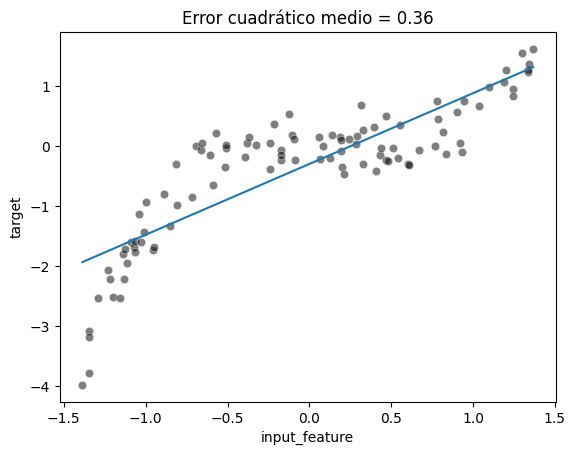

In [6]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

In [7]:
# Aquí el coeficiente e intercepción aprendidos por LinearRegression define la mejor "línea recta" que se ajusta a los datos. 
# Podemos inspeccionar los coeficientes utilizando los atributos del modelo aprendidos de la siguiente manera:

print(f"peso: {linear_regression.coef_[0]:.2f}, "
      f"intercepción: {linear_regression.intercept_:.2f}")

peso: 1.18, intercepción: -0.29


Es importante tener en cuenta que el modelo aprendido no podrá manejar la relación no lineal entre los datos y el objetivo, ya que los modelos lineales asumen que la relación entre los datos y el objetivo es lineal.

De hecho, hay 3 posibilidades para resolver este problema:
1. Elegir un modelo que pueda lidiar de forma nativa con la no linealidad,
2. Generar, mediante ingeniería, un conjunto más rico de características (al incluir conocimiento experto) que pueda ser utilizado directamente por un modelo lineal simple, o
3. Usar un "núcleo (kernel)" para tener una función de decisión local en lugar de una función de decisión lineal global.

### 1. Usar un regresor de árbol de decisión que puede manejar de forma nativa la no linealidad.

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3).fit(data, target)
target_predicted = tree.predict(data)
mse = mean_squared_error(target, target_predicted)

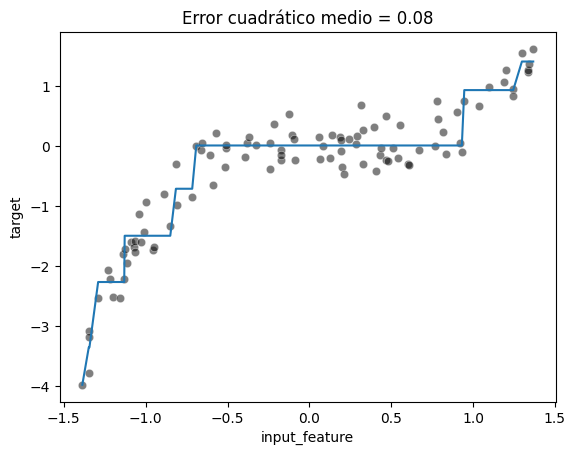

In [9]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

### 2. En lugar de tener un modelo que pueda lidiar de forma nativa con la no linealidad, también podríamos modificar nuestros datos:
- Podemos crear nuevas características, derivadas de las características originales, utilizando conocimiento experto. 
    - En este ejemplo, sabemos que tenemos una relación cúbica y cuadrada entre los datos y el objetivo (a partir de cómo se han generado los datos).
- Podemos crear dos nuevas características (datos ** 2 y datos ** 3)
    - **Este tipo de transformación se llama expansión de características polinómicas:**

In [10]:
data.shape

(100, 1)

In [11]:
data_expanded = np.concatenate([data, data ** 2, data ** 3], axis=1)
data_expanded.shape

(100, 3)

In [12]:
linear_regression.fit(data_expanded, target)
target_predicted = linear_regression.predict(data_expanded)
mse = mean_squared_error(target, target_predicted)

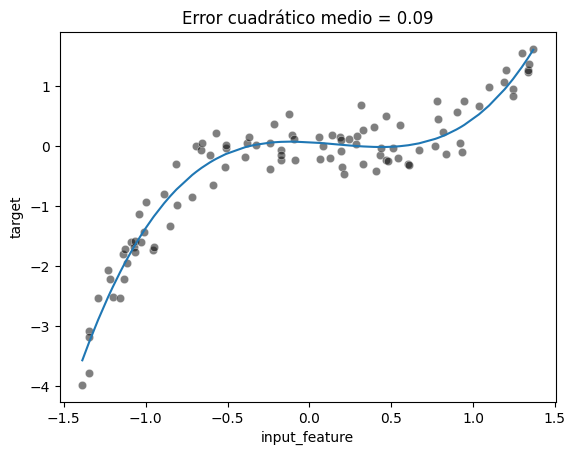

In [13]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

Podemos ver que incluso con un modelo lineal, podemos superar la limitación de linealidad del modelo agregando los componentes no lineales en el diseño de características adicionales.- Aquí, creamos nuevas características sabiendo la forma en que se generó el target.

> **En lugar de crear manualmente estas características polinomiales, se puede usar directamente `sklearn.preprocessing.PolynomialFeatures`.**

In [14]:
# Para demostrar el uso de la clase PolynomialFeatures, usamos un pipeline donde primero transforma las características y luego se ajusta al modelo de regresión.

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    LinearRegression(),
)
polynomial_regression.fit(data, target)
target_predicted = polynomial_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

En la celda anterior tuvimos que configurar `include_bias = False`, de lo contrario, crearíamos una columna perfectamente correlacionada con el `intercept_` introducido por LinearRegression. 

Podemos verificar que este procedimiento sea equivalente a crear las características a mano hasta un error numérico, calculando el máximo de los valores absolutos de las diferencias entre las características generadas por ambos métodos y verificación de que está cerca de cero:

In [15]:
np.abs(polynomial_regression[0].fit_transform(data) - data_expanded).max()

2.220446049250313e-16

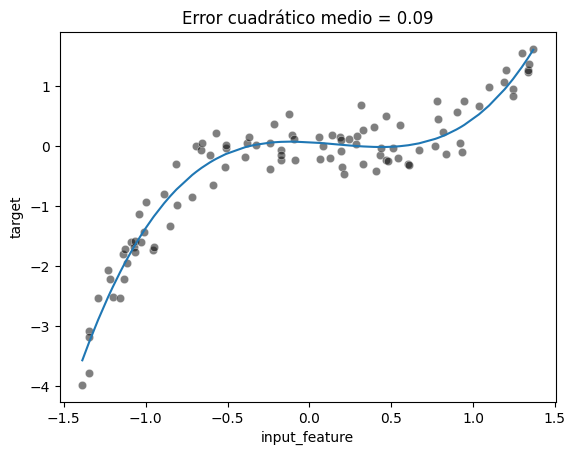

In [16]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

### 3. La última posibilidad es hacer que un modelo lineal sea más expresivo es usar un **“kernel”**.
En lugar de aprender un peso por característica, como hemos enfatizado anteriormente, se asignará un peso a cada muestra.
- Sin embargo, no todas las muestras se utilizarán.
- Esta es la base del algoritmo *máquinas de vectores de soporte* (SVMs).

Desarrollemos algunas intuiciones en la potencia expresiva relativa a SVMs con núcleos (kernels) **lineales** y **no lineales** al instalarlas en el mismo conjunto de datos.

In [17]:
# Primero, SVM con un kernel lineal:

from sklearn.svm import SVR

svr = SVR(kernel="linear")
svr.fit(data, target)
target_predicted = svr.predict(data)
mse = mean_squared_error(target, target_predicted)

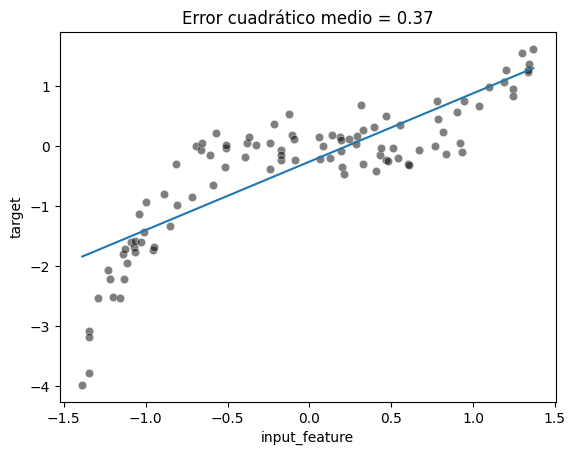

In [18]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

El estimador también se puede configurar para usar un **núcleo no lineal**. 

In [19]:
# El resultado es otro tipo de modelo de regresión no lineal con una expresividad similar a la pipeline de regresión polinómica anterior:

svr = SVR(kernel="poly", degree=3)
svr.fit(data, target)
target_predicted = svr.predict(data)
mse = mean_squared_error(target, target_predicted)

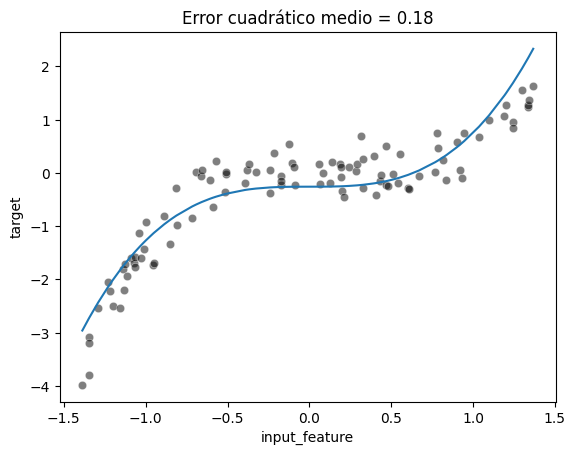

In [20]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

Los métodos de kernel, como SVM, son muy eficientes para datasets pequeños-medianos.

Para datasets más grandes con *n_samples >> 10_000*, a menudo es computacionalmente más eficiente realizar una expansión de características explícitas usando `PolynomialFeatures` u otros transformadores no lineales de Scikit-Learn como `KBinsDiscretizer` o `Nystroem`.

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

binned_regression = make_pipeline(
    KBinsDiscretizer(n_bins=8), LinearRegression(),
)
binned_regression.fit(data, target)
target_predicted = binned_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

In [ ]:
from sklearn.kernel_approximation import Nystroem

nystroem_regression = make_pipeline(
    Nystroem(n_components=5), LinearRegression(),
)
nystroem_regression.fit(data, target)
target_predicted = nystroem_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
_ = ax.set_title(f"Error cuadrático medio = {mse:.2f}")

## Ejercicio:

Para el dataset de pingüinos (data/penguins/penguins.csv)
- Crea un pipeline con [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)  y regresión lineal.
    - `degree=2` y `interaction_only=True` para el PolynomialFeatures.
- Usa:
    - `columns = ["Flipper Length (mm)", "Culmen Length (mm)", "Culmen Depth (mm)"]`
    - `target_name = "Body Mass (g)"`
- Evalúa como la métrica de `neg_mean_absolute_error` mejora al introducir la no linealidad.
- Compara con usar SVM con nucleo no lineal.